<a href="https://colab.research.google.com/github/fabio-baum/analise_otimizacao_processos/blob/main/B_Opt__Linha_2025_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload the 100-point dataframe (CSV with columns x,y):


Saving Linha.xlsx to Linha (7).xlsx
Dataframe loaded with 100 points.


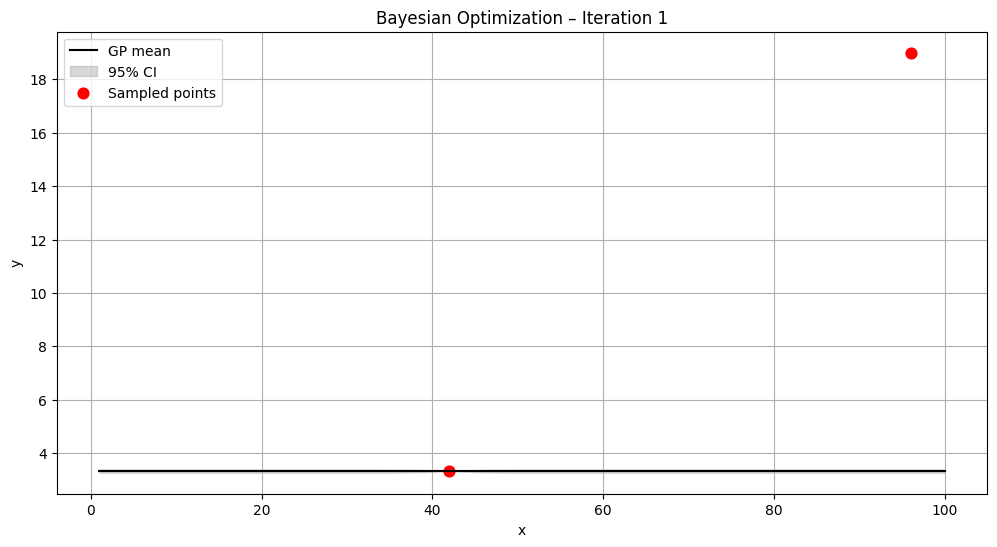


Press ENTER to proceed to iteration 2...



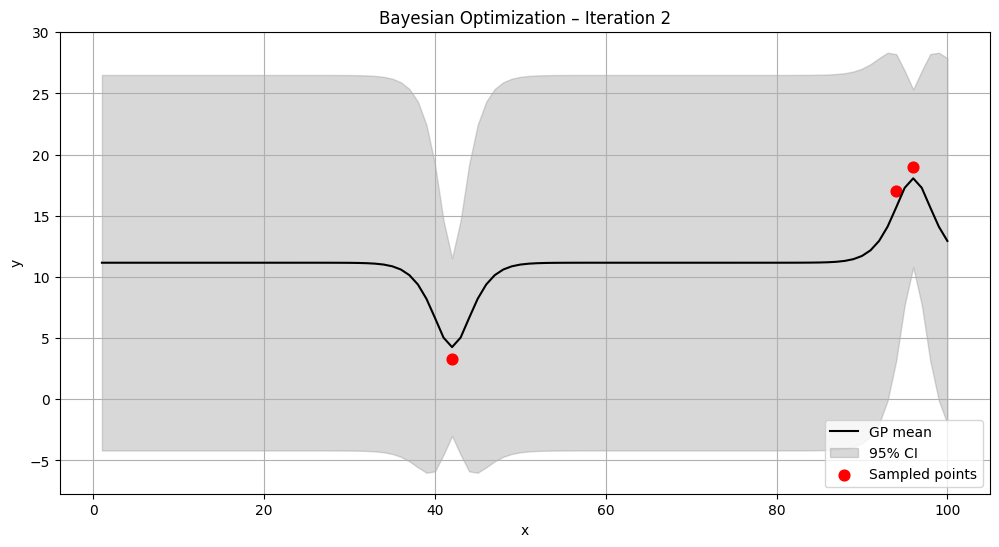


Press ENTER to proceed to iteration 3...



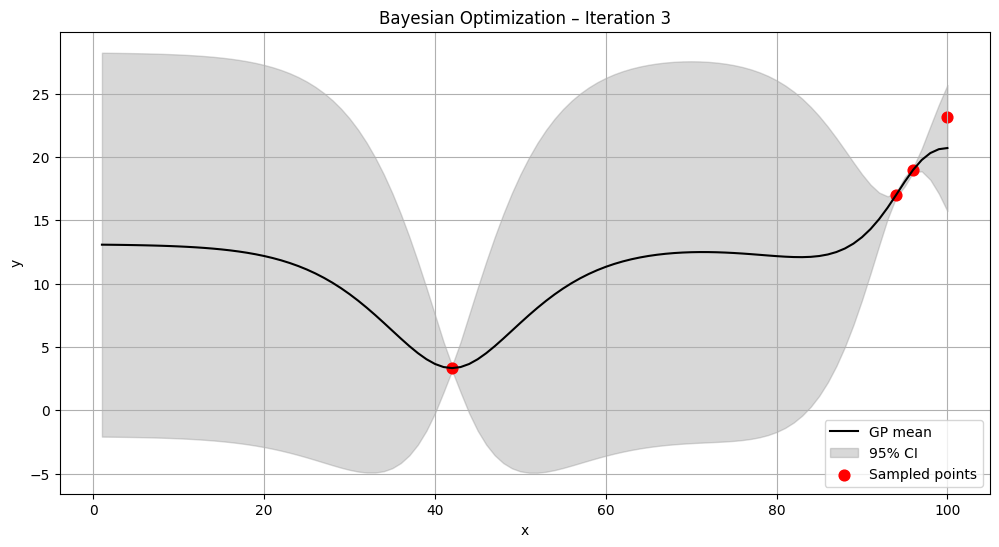


Press ENTER to proceed to iteration 4...



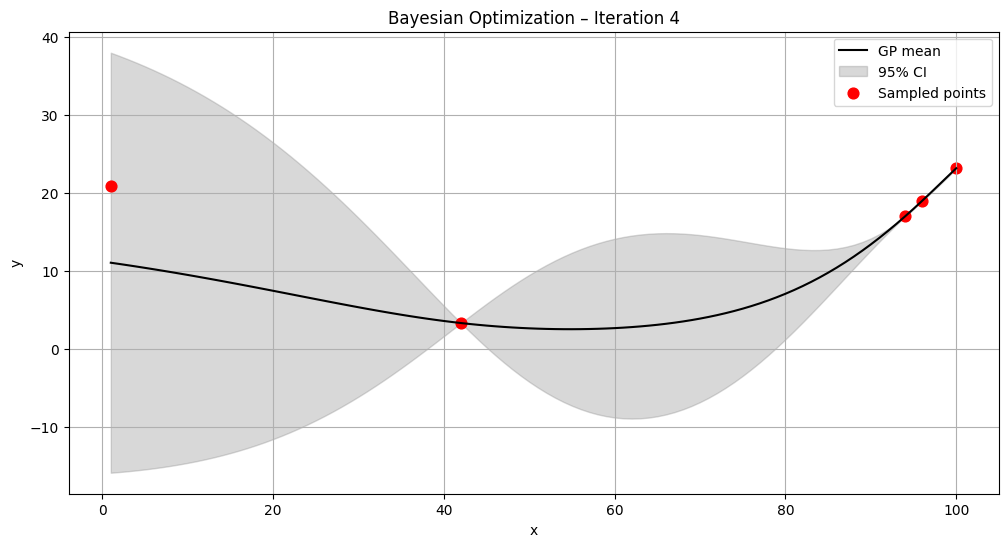


Press ENTER to proceed to iteration 5...



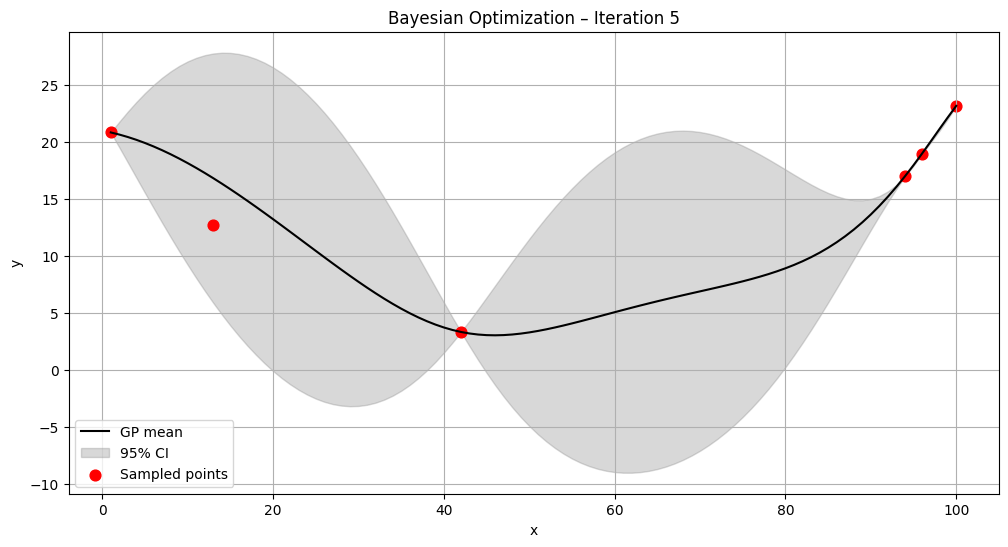


Press ENTER to proceed to iteration 6...



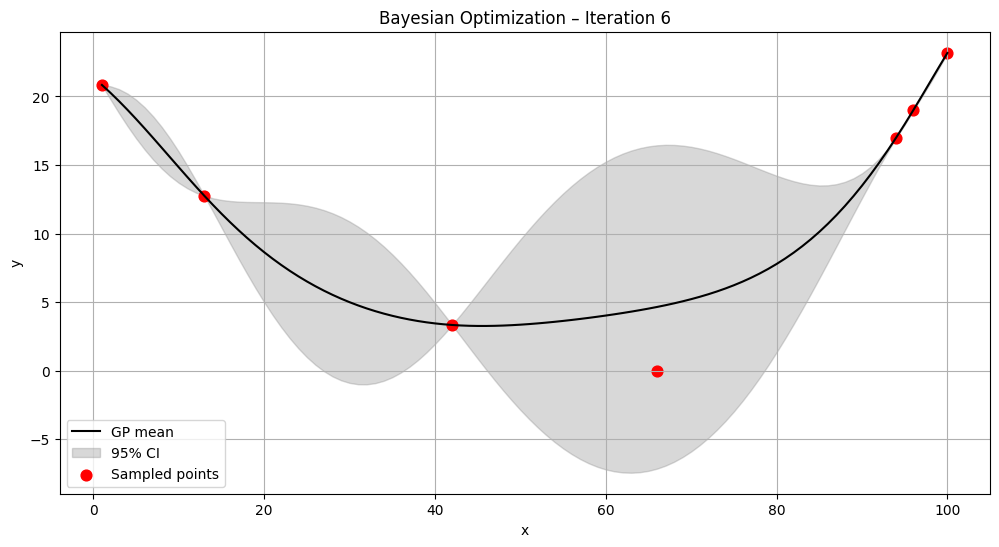


Press ENTER to proceed to iteration 7...



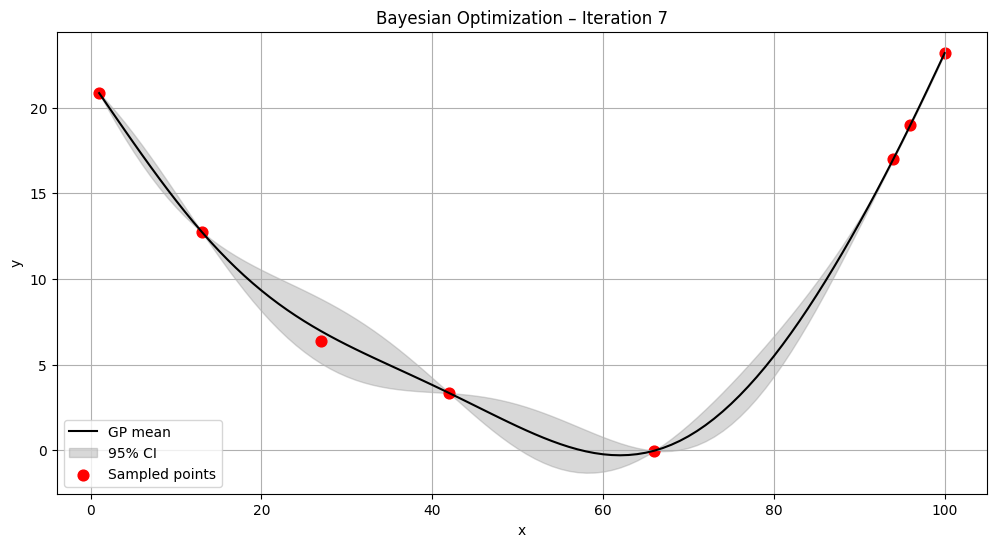


Press ENTER to proceed to iteration 8...



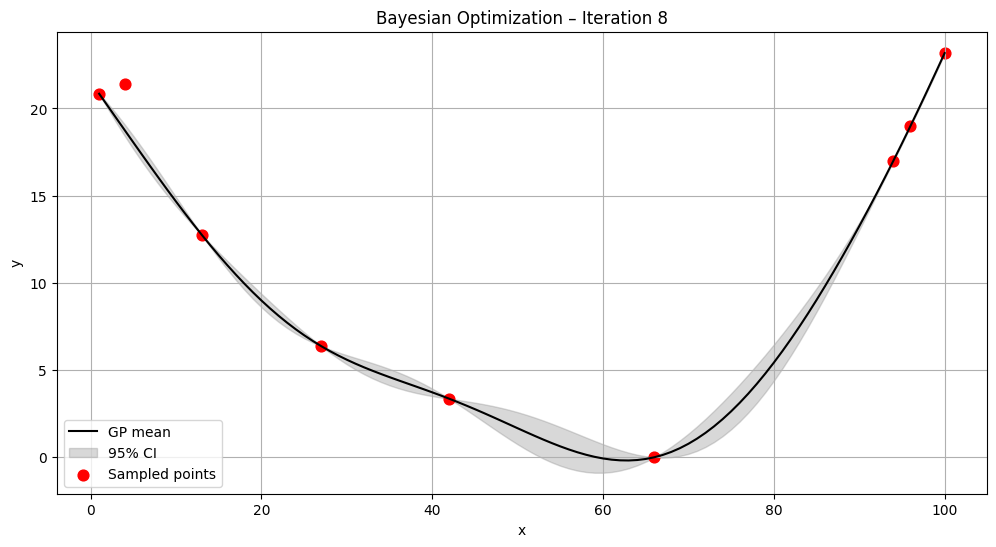


Press ENTER to proceed to iteration 9...



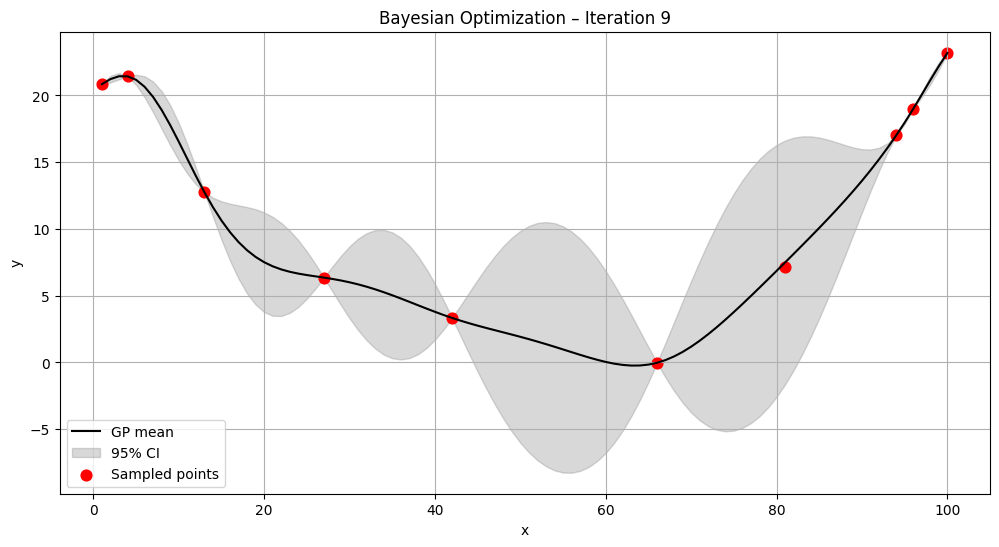


Press ENTER to proceed to iteration 10...



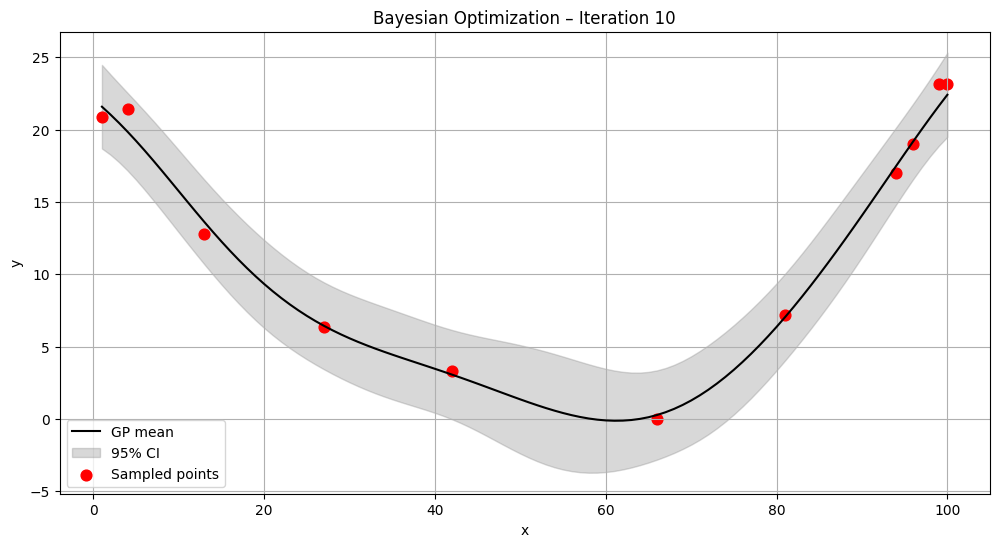


Press ENTER to proceed to iteration 11...



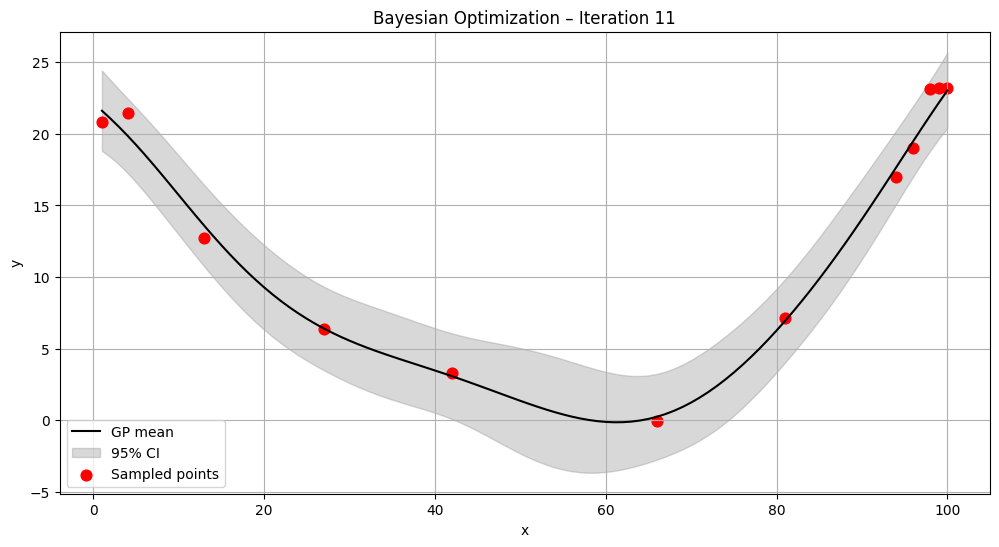


Press ENTER to proceed to iteration 12...



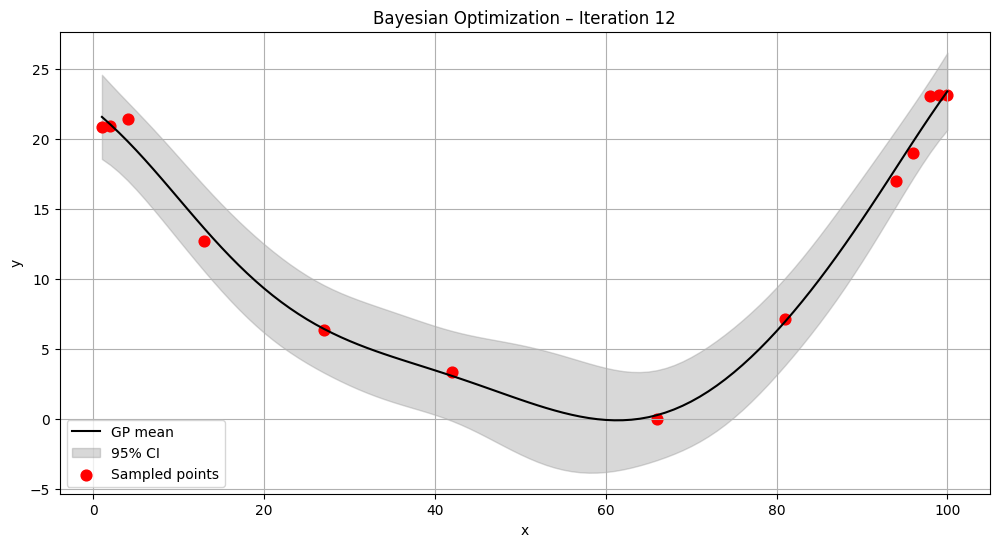


Press ENTER to proceed to iteration 13...



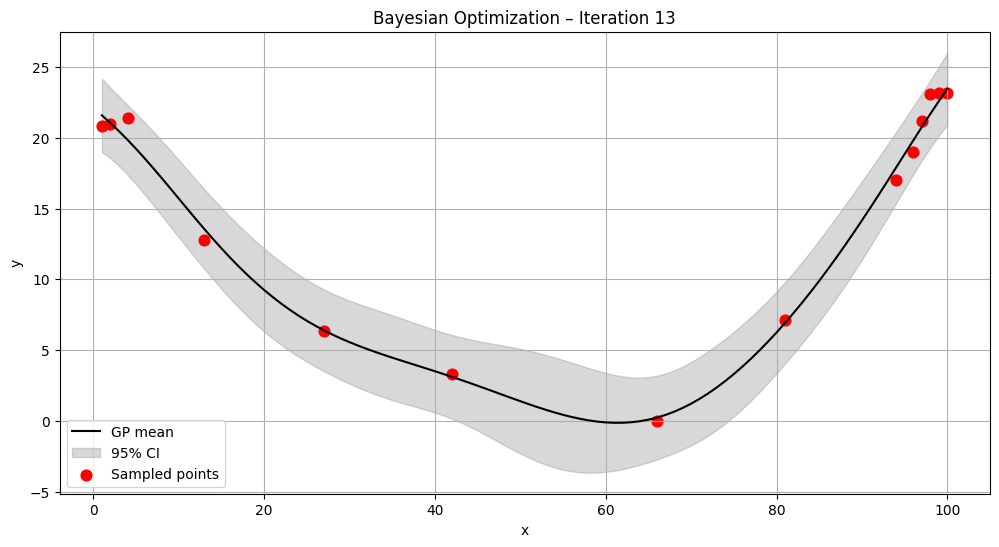


Press ENTER to proceed to iteration 14...



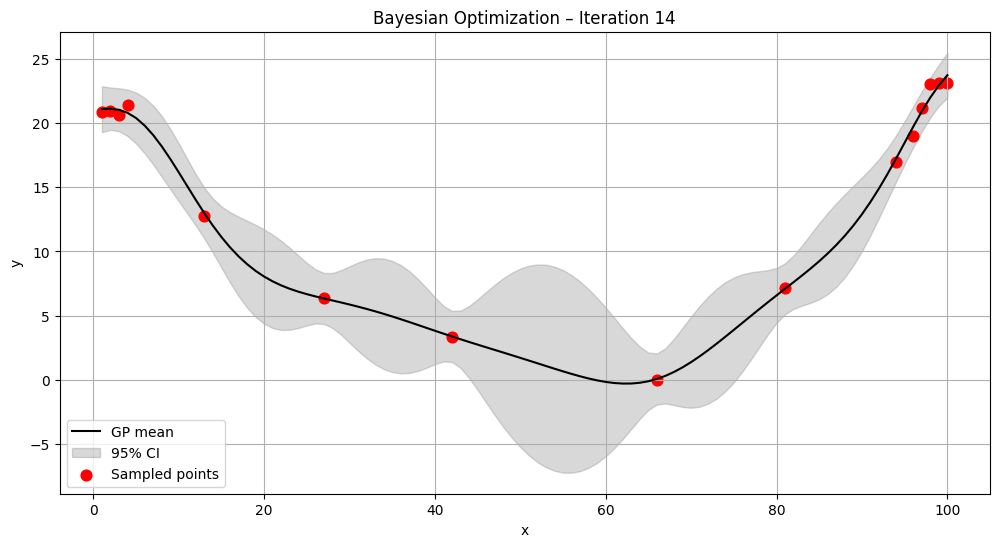


Press ENTER to proceed to iteration 15...



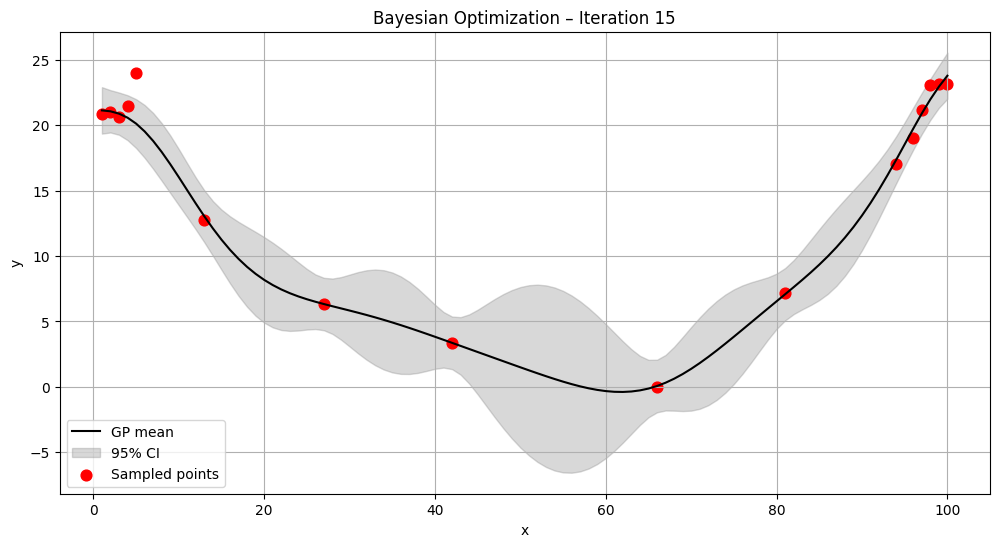


Press ENTER to proceed to iteration 16...



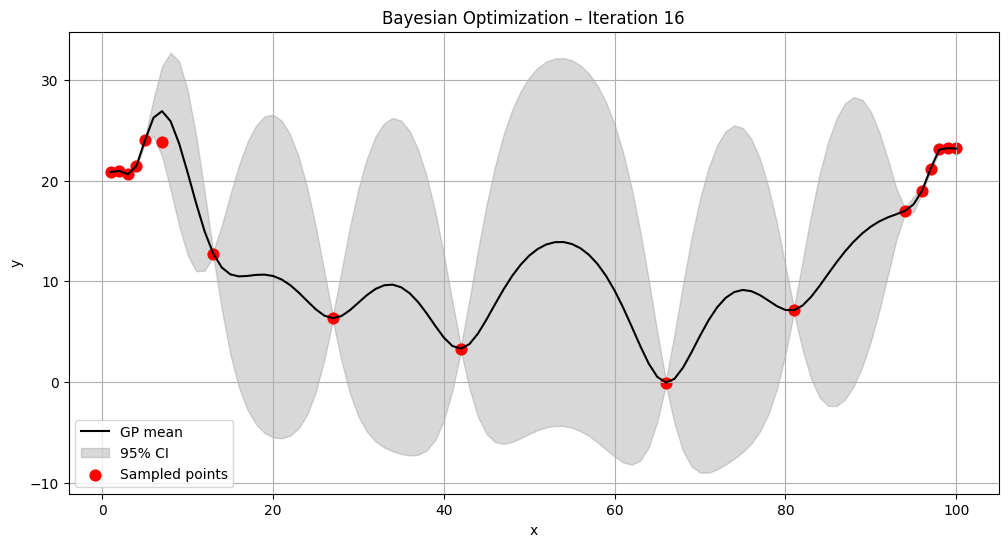


Press ENTER to proceed to iteration 17...



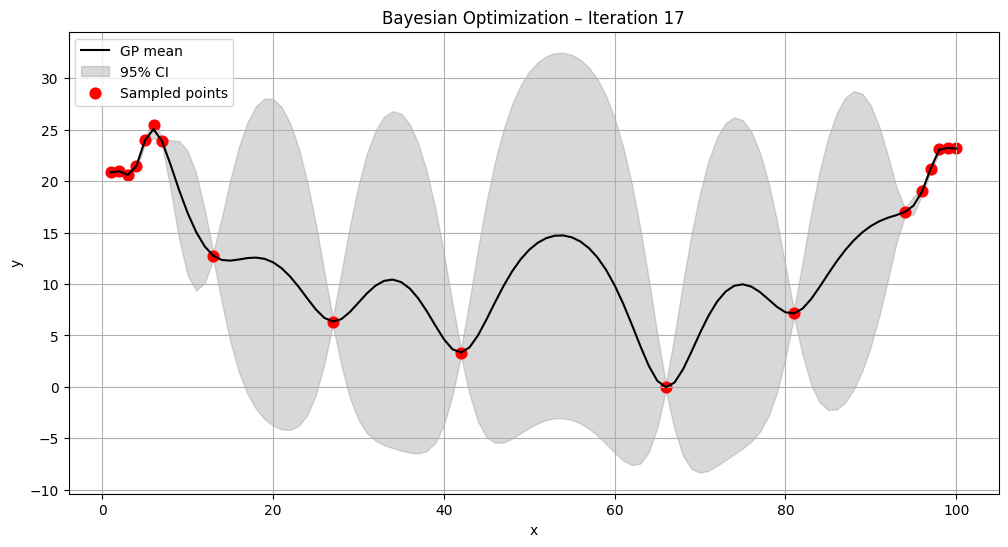


Press ENTER to proceed to iteration 18...



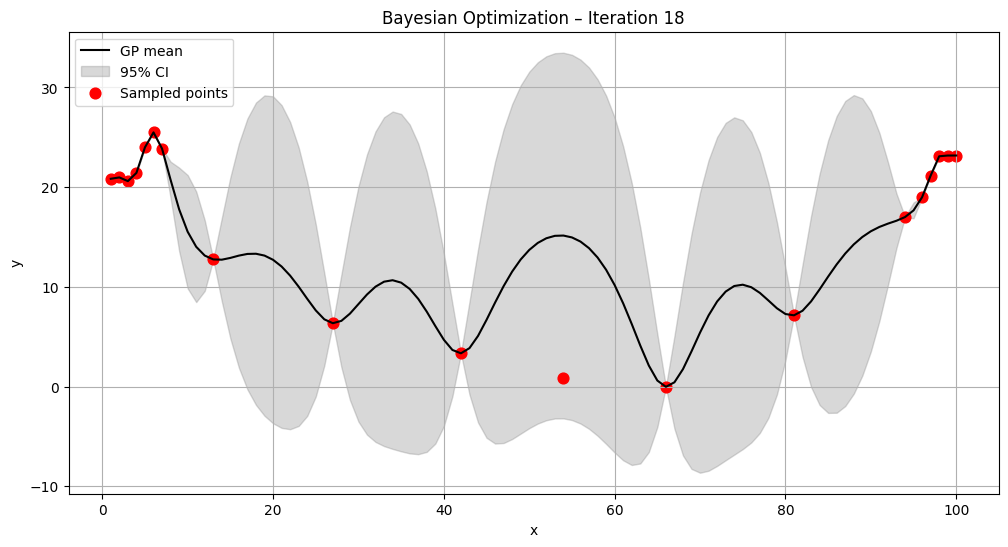


Press ENTER to proceed to iteration 19...



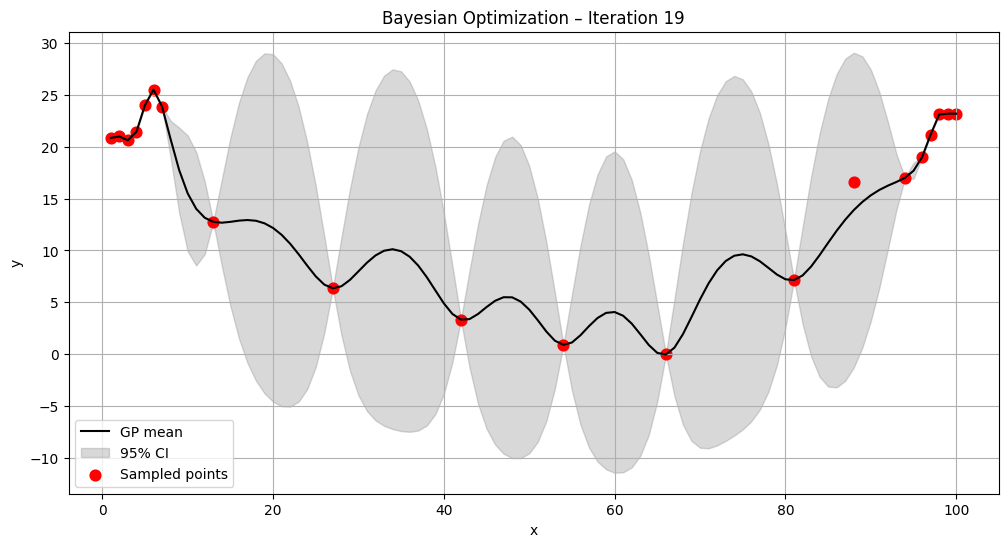


Press ENTER to proceed to iteration 20...



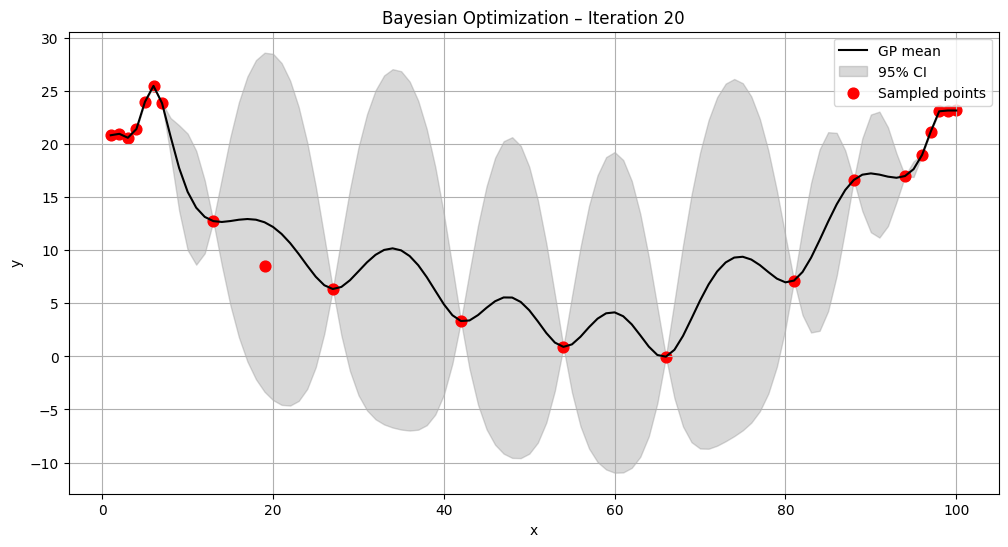


Press ENTER to proceed to iteration 21...

Bayesian Optimization Results:
Predicted optimum x* = 6
Predicted y_max (model) = 25.49473914632459
----------------------------------------------
True optimum x = 6
True y_max = 25.494919035463912


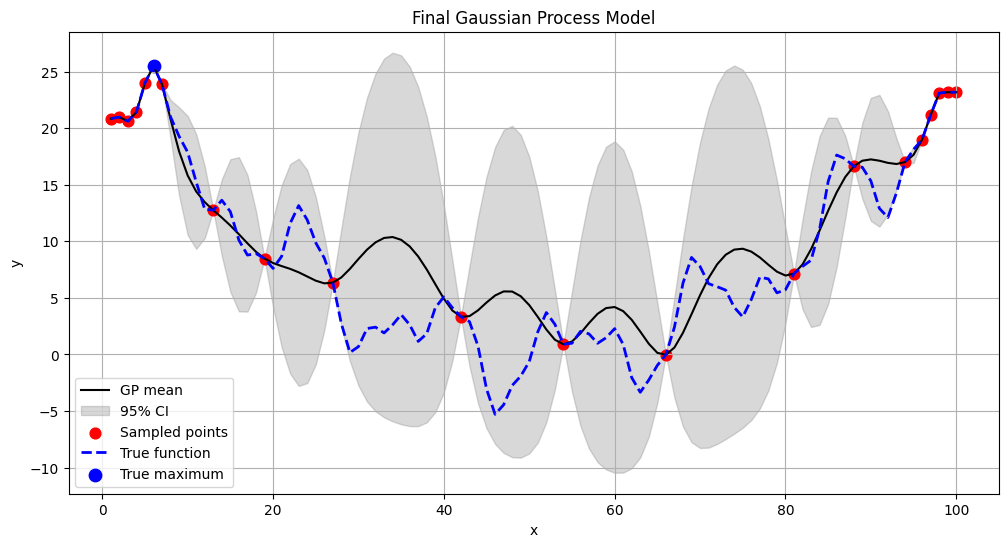

In [9]:
#==============================================================
# 1. Imports
#==============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from google.colab import files

import warnings
warnings.filterwarnings('ignore')

#==============================================================
# 2. Upload Your CSV (must have columns: 'x', 'y')
#==============================================================

print("Upload the 100-point dataframe (CSV with columns x,y):")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

df = pd.read_excel(filename)
df = df.sort_values("x").reset_index(drop=True)

x_all = df["x"].values.reshape(-1,1)
y_all = df["y"].values

print("Dataframe loaded with", len(df), "points.")

#==============================================================
# 3. Gaussian Process Model
#==============================================================
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=5.0, nu=2.5) \
         + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1e2))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=2,
    normalize_y=True
)

#==============================================================
# 4. Acquisition Function: Expected Improvement
#==============================================================
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gp):
    mu, sigma = gp.predict(X, return_std=True)

    mu_sample_opt = np.max(Y_sample)

    # sigma is already (N,) — leave as is!
    with np.errstate(divide='ignore'):
        Z = (mu - mu_sample_opt) / sigma
        ei = (mu - mu_sample_opt) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

#==============================================================
# 5. Plotting Function
#==============================================================
def plot_iteration(X_obs, Y_obs, gp, iteration):
    X = x_all
    mu, std = gp.predict(X, return_std=True)

    plt.figure(figsize=(12,6))
    plt.title(f"Bayesian Optimization – Iteration {iteration}")

    # GP mean prediction
    plt.plot(X, mu, "k", label="GP mean")

    # confidence interval
    plt.fill_between(X.ravel(),
                     mu - 1.96*std,
                     mu + 1.96*std,
                     color="gray", alpha=0.3, label="95% CI")

    # sampled data
    plt.scatter(X_obs, Y_obs, color="red", s=60, label="Sampled points")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

#==============================================================
# 6. Bayesian Optimization Loop
#==============================================================

# Initial random point
initial_idx = np.random.randint(0, len(df))

X_obs = x_all[initial_idx:initial_idx+1]
Y_obs = y_all[initial_idx:initial_idx+1]

n_iterations = 20  # you can change

for i in range(1, n_iterations+1):
    # Fit GP
    gp.fit(X_obs, Y_obs)

    # Compute EI over all candidate points
    ei = expected_improvement(x_all, X_obs, Y_obs, gp)

    # Prevent selecting an x that has already been sampled
    sampled_indices = [np.where((x_all == xo).all(axis=1))[0][0] for xo in X_obs]
    ei[sampled_indices] = -np.inf

    # Choose next point
    next_idx = np.argmax(ei)
    X_next = x_all[next_idx:next_idx+1]
    Y_next = y_all[next_idx:next_idx+1]

    # Add new observation
    X_obs = np.vstack((X_obs, X_next))
    Y_obs = np.concatenate((Y_obs, Y_next))

    # Plot iteration
    plot_iteration(X_obs, Y_obs, gp, iteration=i)

    # Wait for the user before continuing
    input(f"\nPress ENTER to proceed to iteration {i+1}...\n")

#==============================================================
# 7. Final Result and Comparison
#==============================================================

gp.fit(X_obs, Y_obs)
mu_final, std_final = gp.predict(x_all, return_std=True)

# Model prediction for maximum
x_opt_gpr = x_all[np.argmax(mu_final)][0]
y_opt_gpr = mu_final.max()

# True maximum in the dataframe
idx_true = np.argmax(y_all)
x_true = x_all[idx_true][0]
y_true = y_all[idx_true]

print("==============================================")
print("Bayesian Optimization Results:")
print("Predicted optimum x* =", x_opt_gpr)
print("Predicted y_max (model) =", y_opt_gpr)
print("----------------------------------------------")
print("True optimum x =", x_true)
print("True y_max =", y_true)
print("==============================================")

# Final plot
plt.figure(figsize=(12,6))
plt.title("Final Gaussian Process Model")

# GP mean
plt.plot(x_all, mu_final, "k", label="GP mean")

# 95% CI
plt.fill_between(x_all.ravel(),
                 mu_final - 1.96*std_final,
                 mu_final + 1.96*std_final,
                 color="gray", alpha=0.3, label="95% CI")

# Observed sample points
plt.scatter(X_obs, Y_obs, color="red", s=60, label="Sampled points")

# TRUE VALUES FROM DATAFRAME (dashed line)
plt.plot(x_all, y_all, '--', color="blue", linewidth=2, label="True function")

# True maximum
plt.scatter([x_true], [y_true], color="blue", s=80, label="True maximum")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()
